# MLflow with Microsoft Azure Machine Learning.

MLflow is an open source platform used to manage machine learning lifecycle, including experimentation, reproducibility, deployment and a central model registery. They are characterized by four components: MLflow Tracking (record and query experiments), MLflow Projects (packaging of code for easy reproducibility), MLflow Models (deploying ML models in different environments) and MLflow Registery (sotring, annotating, discovering and managing mdoels in a central repository). Refer [this](https://mlflow.org/) link for more details. Refer [video 1](https://databricks.com/session_eu19/mlflow-and-azure-machine-learning-the-power-couple-for-ml-lifecycle-management), [video 2](https://www.youtube.com/watch?v=2DLG1yo8JxM) and [this link](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-use-mlflow) to get an idea about why and how to use MLflow with Azure ML.

This notebook demonstates how one could integrate MLflow with Microsoft Azure ML so that we can leverage the advanatages of both platforms.

In [1]:
# importing necessary libraries
# refer to the requirements.txt file to know the dependencies

import os
import json
import requests
import mlflow
import azureml.core
import mlflow.azureml
from dotenv import load_dotenv
from azureml.core.model import Model
from azureml.core.model import InferenceConfig
from azureml.core import Workspace, Experiment, Run, ScriptRunConfig, Environment
from azureml.core.compute import AksCompute, ComputeTarget
from azureml.core.webservice import AksWebservice, AciWebservice
from azureml.mlflow import get_portal_url
from IPython.core.display import display, HTML

print(f"Azure-core Python SDK version -> {azureml.core.VERSION}")
print(f"MLflow version -> {mlflow.version.VERSION}")
load_dotenv()

Azure-core Python SDK version -> 1.28.0
MLflow version -> 1.17.0


True

In [2]:
# fetching our workspace

workspace = Workspace.get(name=os.getenv("WORKSPACE_NAME", None),
                          subscription_id=os.getenv("SUBSCRIPTION_ID", None),
                          resource_group=os.getenv("RESOURCE_GROUP", None))
print(f'''Workspace name: {workspace.name}\nWorkspace region: {workspace.location}\nWorkspace subscription ID: {workspace.subscription_id[:3]}---xxxx---{workspace.subscription_id[-3:]}\nWorkspace resource group: {workspace.resource_group}''')

Workspace name: ML_WORKSPACE_VERSION_1
Workspace region: centralindia
Workspace subscription ID: 200---xxxx---ee2
Workspace resource group: ML_VERSION_1


In [3]:
# linking MLflow tracking to the Azure ML workspace (basically, exchanging information between MLflow and Azure ML).

mlflow.set_tracking_uri(uri=workspace.get_mlflow_tracking_uri())

In [4]:
# setting up an experiment

experiment_name = "digit-recognizer-mlflow-experiment-3"
experiment = Experiment(workspace=workspace, name=experiment_name)
mlflow.set_experiment(experiment_name=experiment_name)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


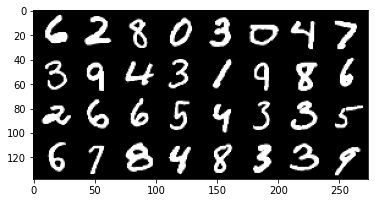


DEVICE - cuda || EPOCHS - 10 || LEARNING RATE - 0.001.


EPOCH - 1/10 || START AT - 20:42:27 21|05|2021 || LEARNING RATE - 0.001

	Train Step - 500/1875 | Train Step Loss: 2.24745 | Time: 3.15s.

	Train Step - 1000/1875 | Train Step Loss: 0.72464 | Time: 3.13s.

	Train Step - 1500/1875 | Train Step Loss: 0.37702 | Time: 3.15s.

	EPOCH - 1/10 || TRAIN LOSS - 0.95497 || TIME ELAPSED - 12.29s.


EPOCH - 2/10 || START AT - 20:42:39 21|05|2021 || LEARNING RATE - 0.001

	Train Step - 500/1875 | Train Step Loss: 0.25254 | Time: 3.25s.

	Train Step - 1000/1875 | Train Step Loss: 0.20950 | Time: 3.07s.

	Train Step - 1500/1875 | Train Step Loss: 0.19681 | Time: 3.06s.

	EPOCH - 2/10 || TRAIN LOSS - 0.20981 || TIME ELAPSED - 12.16s.


EPOCH - 3/10 || START AT - 20:42:51 21|05|2021 || LEARNING RATE - 0.001

	Train Step - 500/1875 | Train Step Loss: 0.15631 | Time: 3.06s.

	Train Step - 1000/1875 | Train Step Loss: 0.13523 | Time: 3.05s.

	Train Step - 1500/1875 | Train Step Loss: 0.12929 | Time:

In [9]:
# running the experiment (locally)

with mlflow.start_run() as run:
    display(HTML(f"<a href={get_portal_url(run)} target='_blank'>Click the link to checkout the Azure ML run details : {run.info.run_uuid}</a>"))
    %run train_cloud.py --mlflow True

In [5]:
# running the project and saving run details (remotely)
# the same may be configured to run locally by removing "COMPUTE" key from the "backend_config.json" file

backend_config = None
with open("backend_config.json") as f:
    backend_config = json.load(f)
mlflow_project_run = mlflow.projects.run(uri='.',
                                         parameters={"learning_rate": 1e-2, "momentum": 0.9, "mlflow": True},
                                         backend="azureml",
                                         backend_config=backend_config)
run_details = {}
run_details['experiment_name'] = experiment.name
run_details['run_id'] = mlflow_project_run.run_id
if os.path.isfile("run_config.json"):
    os.remove("run_config.json")
with open("run_config.json", 'w') as f:
    json.dump(run_details, f)

Class AzureMLProjectBackend: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
2021/05/24 22:31:24 INFO mlflow.projects.utils: === Created directory /tmp/tmposgspmma for downloading remote URIs passed to arguments of type 'path' ===
'enabled' is deprecated. Please use the azureml.core.runconfig.DockerConfiguration object with the 'use_docker' param instead.
Submitting /media/tyche/E/ACTIVITIES/Co-curricular/AI mini projects/Lenet directory for run. The size of the directory >= 25 MB, so it can take a few minutes.
Class AzureMLSubmittedRun: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


RunId: digit-recognizer-mlflow-experiment-3_1621875686_7ca94843
Web View: https://ml.azure.com/runs/digit-recognizer-mlflow-experiment-3_1621875686_7ca94843?wsid=/subscriptions/2006ce9b-738e-4ab3-82ce-eb92cd6cbee2/resourcegroups/ML_VERSION_1/workspaces/ML_WORKSPACE_VERSION_1&tid=1d331154-fec8-49f7-a7ca-7c22a79641cb

Streaming azureml-logs/55_azureml-execution-tvmps_5a4ad08c9a271e26493b57a4b9bde00867d0d61aae07b826ec6ac07a5b6fb493_d.txt

2021-05-24T17:05:54Z Successfully mounted a/an Blobfuse File System at /mnt/batch/tasks/shared/LS_root/jobs/ml_workspace_version_1/azureml/digit-recognizer-mlflow-experiment-3_1621875686_7ca94843/mounts/workspaceblobstore
2021-05-24T17:05:55Z Starting output-watcher...
2021-05-24T17:05:55Z IsDedicatedCompute == True, won't poll for Low Pri Preemption
2021-05-24T17:05:55Z Executing 'Copy ACR Details file' on 10.0.0.5
2021-05-24T17:05:55Z Copy ACR Details file succeeded on 10.0.0.5. Output: 
>>>   
>>>   
Login Succeeded
Using default tag: latest
latest: P

2021/05/24 22:46:05 INFO mlflow.projects: === Run (ID 'digit-recognizer-mlflow-experiment-3_1621875686_7ca94843') succeeded ===


In [6]:
# register the model

run_config = None
with open("run_config.json") as f:
    run_config = json.load(f)
experiment = Experiment(workspace=workspace, name=run_config["experiment_name"])
run = Run(experiment=experiment, run_id=run_config["run_id"])
model = run.register_model(model_name="vanilla_digit_recognizer_model",
                           # model_path is the path of the saved model, refer 'train_cloud.py' file
                           model_path="model",
                           tags={"Creator_v1": "Github actions - v1"},
                           description="Digit recognizer using MLflow-github actions.")

In [7]:
# vanilla - deploying MLflow models - ACI

env = Environment.from_pip_requirements(name="digit_recognizer_environment", file_path="./requirements.txt")
inference_config = InferenceConfig(environment=env,
                                   source_directory="./source_dir",
                                   entry_script="./entry_point.py")
deployment_config = AciWebservice.deploy_configuration(cpu_cores=1, 
                                                       memory_gb=4,
                                                       description='Digit recognizer')
deploy = Model(workspace=workspace, id=model.id)
service = Model.deploy(workspace=workspace,
                       name="aci-deploy-vanilla",
                       models=[model],
                       inference_config=inference_config,
                       deployment_config=deployment_config,
                       overwrite=True,
                       show_output=True)
service.wait_for_deployment(show_output=True)
print(service.get_logs())                                                       

Models: ['vanilla_digit_recognizer_model:2']
Entry script: source_dir/./entry_point.py
Environment dependencies: ['python=3.6.2', ordereddict([('pip', ['numpy', 'matplotlib', 'opencv-python', 'torch', 'torchvision', 'easydict', 'python-dotenv', 'azureml-defaults', 'azureml-core', 'azureml-train', 'mlflow', 'azureml-mlflow', 'azureml-pipeline', 'azureml-widgets', 'azureml-contrib-services'])]), 'pip']
Environment docker image: mcr.microsoft.com/azureml/openmpi3.1.2-ubuntu18.04:20210301.v1
CPU requirement: 1, Memory requirement: 4GB
Uploading dependency /tmp/tmpsju_lrtt/f780cb8c.tar.gz.
Request submitted, please run wait_for_deployment(show_output=True) to get deployment status.
Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-05-24 22:46:47+05:30 Creating Container Registry if not exists.
2021-05-24 22:46:47+05:30 Registering the environment.
20

In [8]:
# details to access ACI deployment
scoring_uri = service.scoring_uri
print(f"Uri -> {scoring_uri}")

Uri -> http://cbedfa1a-38aa-4258-a793-764cd5d1f906.centralindia.azurecontainer.io/score


In [9]:
# vanilla - deploying MLflow models - AKS

# attach aks
aks_name = 'mlflowaksv1'
resource_group = 'ML_VERSION_1'
try:
    aks_target = AksCompute(workspace=workspace, name="mlflowaksv1")
except Exception as e:
    print("Attaching AKS to workspace...")
    attach_config = AksCompute.attach_configuration(resource_group = resource_group,
                                                    cluster_name = aks_name,
                                                    cluster_purpose = AksCompute.ClusterPurpose.DEV_TEST)
    aks_target = ComputeTarget.attach(workspace=workspace, 
                                    name=aks_name, 
                                    attach_configuration=attach_config)
    aks_target.wait_for_completion(show_output = True)

try:
    env = Environment.from_pip_requirements(name="digit_recognizer_environment", file_path="./requirements.txt")
    inference_config = InferenceConfig(environment=env,
                                    source_directory="./source_dir",
                                    entry_script="./entry_point.py")
    deployment_config = AksWebservice.deploy_configuration(enable_app_insights=True,
                                                        compute_target_name=aks_name)
    deploy = Model(workspace=workspace, id=model.id)
    service = Model.deploy(workspace=workspace,
                        name="aks-deploy-vanilla",
                        models=[model],
                        inference_config=inference_config,
                        deployment_config=deployment_config,
                        overwrite=True,
                        show_output=True)
    service.wait_for_deployment(show_output=True)
    print(service.get_logs())  
except Exception as e:
    print(e)
    aks_target.detach()

Models: ['vanilla_digit_recognizer_model:2']
Entry script: source_dir/./entry_point.py
Environment dependencies: ['python=3.6.2', ordereddict([('pip', ['numpy', 'matplotlib', 'opencv-python', 'torch', 'torchvision', 'easydict', 'python-dotenv', 'azureml-defaults', 'azureml-core', 'azureml-train', 'mlflow', 'azureml-mlflow', 'azureml-pipeline', 'azureml-widgets', 'azureml-contrib-services'])]), 'pip']
Environment docker image: mcr.microsoft.com/azureml/openmpi3.1.2-ubuntu18.04:20210301.v1
Uploading dependency /tmp/tmpo5cfjsuo/175768b2.tar.gz.
Request submitted, please run wait_for_deployment(show_output=True) to get deployment status.
Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-05-24 22:53:37+05:30 Creating Container Registry if not exists.
2021-05-24 22:53:37+05:30 Registering the environment.
2021-05-24 22:53:38+05:30 Use the existing ima

In [10]:
# details to access AKS deployment
scoring_uri = service.scoring_uri
key, _ = service.get_keys()
print(f"Uri -> {scoring_uri}\nkey -> Bearer {key}")

Uri -> http://20.193.244.3:80/api/v1/service/aks-deploy-vanilla/score
key -> Bearer R5JVutRciuZcxMpHnVRHn3fufHDZwpa2


In [ ]:
# # deploying MLflow models - ACI

# run_config = None
# with open("run_config.json") as f:
#     run_config = json.load(f)
# aci_deployment_config = AciWebservice.deploy_configuration(cpu_cores=1, memory_gb=4)
# dev_aci_service = mlflow.azureml.deploy(model_uri=f"runs:/{run_config['run_id']}/model",
#                                         workspace=workspace,
#                                         deployment_config=aci_deployment_config,
#                                         service_name="aci-deploy-mlflow",
#                                         model_name="mlflow_digit_recognizer")

In [ ]:
# # deploying MLflow models - kubernetes
# # remeber to create a aks clusture first (UI or SDK) and then attach it to the workspace

# # attach aks
# aks_name = 'mlflowaksv1'
# resource_group = 'ML_VERSION_1'
# try:
#     aks_target = AksCompute(workspace=workspace, name="mlflowaksv1")
# except Exception as e:
#     print("Attaching AKS to workspace...")
#     attach_config = AksCompute.attach_configuration(resource_group = resource_group,
#                                                     cluster_name = aks_name,
#                                                     cluster_purpose = AksCompute.ClusterPurpose.DEV_TEST)
#     aks_target = ComputeTarget.attach(workspace=workspace, 
#                                     name=aks_name, 
#                                     attach_configuration=attach_config)
#     aks_target.wait_for_completion(show_output = True)

# # deploy
# try:
#     run_config = None
#     with open("run_config.json") as f:
#         run_config = json.load(f)
#     aks_deployment_config = AksWebservice.deploy_configuration(enable_app_insights=True, compute_target_name=aks_name)
#     # model_uri is the path of the saved model, refer 'train_cloud.py' file
#     dev_aks_service = mlflow.azureml.deploy(model_uri=f"runs:/{run_config['run_id']}/model",
#                                             workspace=workspace,
#                                             deployment_config=aks_deployment_config,
#                                             service_name="aks-deploy-mlflow",
#                                             model_name="mlflow_digit_recognizer")
# except Exception as e:
#     print(e)
#     aks_target.detach()